## load dependencies

In [3]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

# Ultimate analysis

In [2]:
path_to_hpc = '/Users/amir/Desktop/for Abdel/OS Basic/6/Study_day6_HC_28feb2018/Post_trial5_2018-02-28_13-42-34/HPC_100_CH2.continuous.mat'
path_to_states = '/Users/amir/Desktop/for Abdel/OS Basic/6/Study_day6_HC_28feb2018/Post_trial5_2018-02-28_13-42-34/post_trial5_2018-02-28_13-42-34-states.mat'

In [4]:
import os
import re

def extract_experiment_info(path_to_hpc):

    path_parts = os.path.normpath(path_to_hpc).split(os.sep)

    try:
        idx_for_abdel = path_parts.index('for Abdel')
    except ValueError:
        raise ValueError("The path does not contain 'for Abdel' directory.")

    dataset_type = path_parts[idx_for_abdel + 1]

    rat_number = path_parts[idx_for_abdel + 2]

    treatment_part = path_parts[idx_for_abdel + 3]
    if '_' not in treatment_part and ' ' not in treatment_part:

        treatment = treatment_part
    else:

        tokens = re.split(r'[_\-]', treatment_part)

        tokens = [t for t in tokens if not re.match(r'Rat\d*|SD\d*|Rat|Ephys|OS', t, re.IGNORECASE)]

        non_numeric_tokens = [t for t in tokens if not t.isdigit()]
        if non_numeric_tokens:

            treatment = non_numeric_tokens[-1]
        else:
            treatment = 'Unknown'

    post_trial_folder = path_parts[-2]
    post_trial_match = re.search(r'post_trial(\d+)', post_trial_folder, re.IGNORECASE)
    if post_trial_match:
        post_trial = post_trial_match.group(1)
    else:
        post_trial = 'Unknown'

    return {
        'dataset_type': dataset_type,
        'rat_number': rat_number,
        'treatment': treatment,
        'post_trial': post_trial
    }

In [4]:
dataset_info = extract_experiment_info(path_to_hpc)
print(dataset_info)

{'dataset_type': 'OS Basic', 'rat_number': '6', 'treatment': '28feb2018', 'post_trial': '5'}


In [5]:
dataset_info = {'dataset_type': 'OS Basic', 'rat_number': '6', 'treatment': 'HC', 'post_trial': '5'}

In [6]:
dataset_info['dataset_type']

'OS Basic'

In [5]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/OS Basic/emd_masksift_CA1_config_2500.yml')

In [8]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

There was 0 in the dataset


In [10]:
fs

2500

In [6]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [10]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

Number of detected Tonic intrevals:44
Number of detected Tonic intrevals after threshold:44


In [11]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

In [12]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

In [7]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [16]:
start, end = get_start_end(hypno=hypno, sleep_state_id=5)
rem_interval = nap.IntervalSet(start=start, end=end)

# Extract IMFs during REM sleep
rem_imfs, rem_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(
    lfp, fs, rem_interval, config, return_imfs_freqs=True
)

In [8]:
# version 1

def prepare_data_for_umap(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/17

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']
    print(len(cycle_data['theta_imf']))
    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
    # Check if any cycles satisfy the conditions
    if all_cycles is None or all_cycles.chain_vect.size == 0:
        print("No cycles satisfy the conditions.")
        return pd.DataFrame(), pd.DataFrame(), []
    
    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    # Compute mode frequency for each cycle
    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs

In [9]:
def prepare_rem_data_for_umap(imfs, imf_frequencies):
    waveforms = pd.DataFrame()
    all_trials = pd.DataFrame()
    all_FPPs = []

    theta_range = [5, 12]
    frequencies = np.arange(15, 141, 1)
    angles = np.linspace(-180, 180, 19)
    fs = 2500

    for idx, imf in enumerate(imfs):
        cycle_data = get_cycle_data(imf[:, 5], fs=2500)

        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/17

        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']

        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

        subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_cycles_df['index'].values

        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds = arrange_cycle_inds(all_cycles_inds)

        freqs = imf_frequencies[idx]
        sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
        supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

        raw_data = sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5, ret_mode='power', normalise=None)
        supraPlot = scipy.stats.zscore(raw_data, axis=1)
        FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
        all_FPPs.append(FPP)

        mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

        all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                  cycles=all_cycles.iterate(through='subset'), npoints=100)
        all_waveforms = pd.DataFrame(all_waveforms.T)

        waveforms = pd.concat([waveforms, all_waveforms])

        trial = all_cycles.get_metric_dataframe(subset=True)
        trial['mode_freqs'] = mode_freqs
        trial['entropy'] = entropies
        all_trials = pd.concat([all_trials, trial])

    return waveforms, all_trials, all_FPPs

In [19]:
rem_waveforms, rem_trials, rem_FPPs = prepare_rem_data_for_umap(rem_imfs, rem_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton 

In [20]:
print(rem_waveforms.shape)

(7761, 100)


In [21]:
rem_waveforms = np.array(rem_waveforms)

In [22]:
ID = np.round(np.nanmean(abids(rem_waveforms, 50)))
ID

3.0

In [23]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=ID, metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(rem_waveforms)

def project_cycles(waveforms, embedder):
    return embedder.transform(waveforms)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [24]:
phasic_waveforms, phasic_trials, _ = prepare_data_for_umap(phasic_imfs, phasic_imfs_freqs)
tonic_waveforms, tonic_trials, _ = prepare_data_for_umap(tonic_imfs, tonic_imfs_freqs)

phasic_embedding = project_cycles(phasic_waveforms, umap_embedder)
tonic_embedding = project_cycles(tonic_waveforms, umap_embedder)

 Checking Cycles inputs - trimming singleton from input 'IP'
4185
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
3065
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
3285
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
9940
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
5545
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
7060
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
9500
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
11420
 Checking

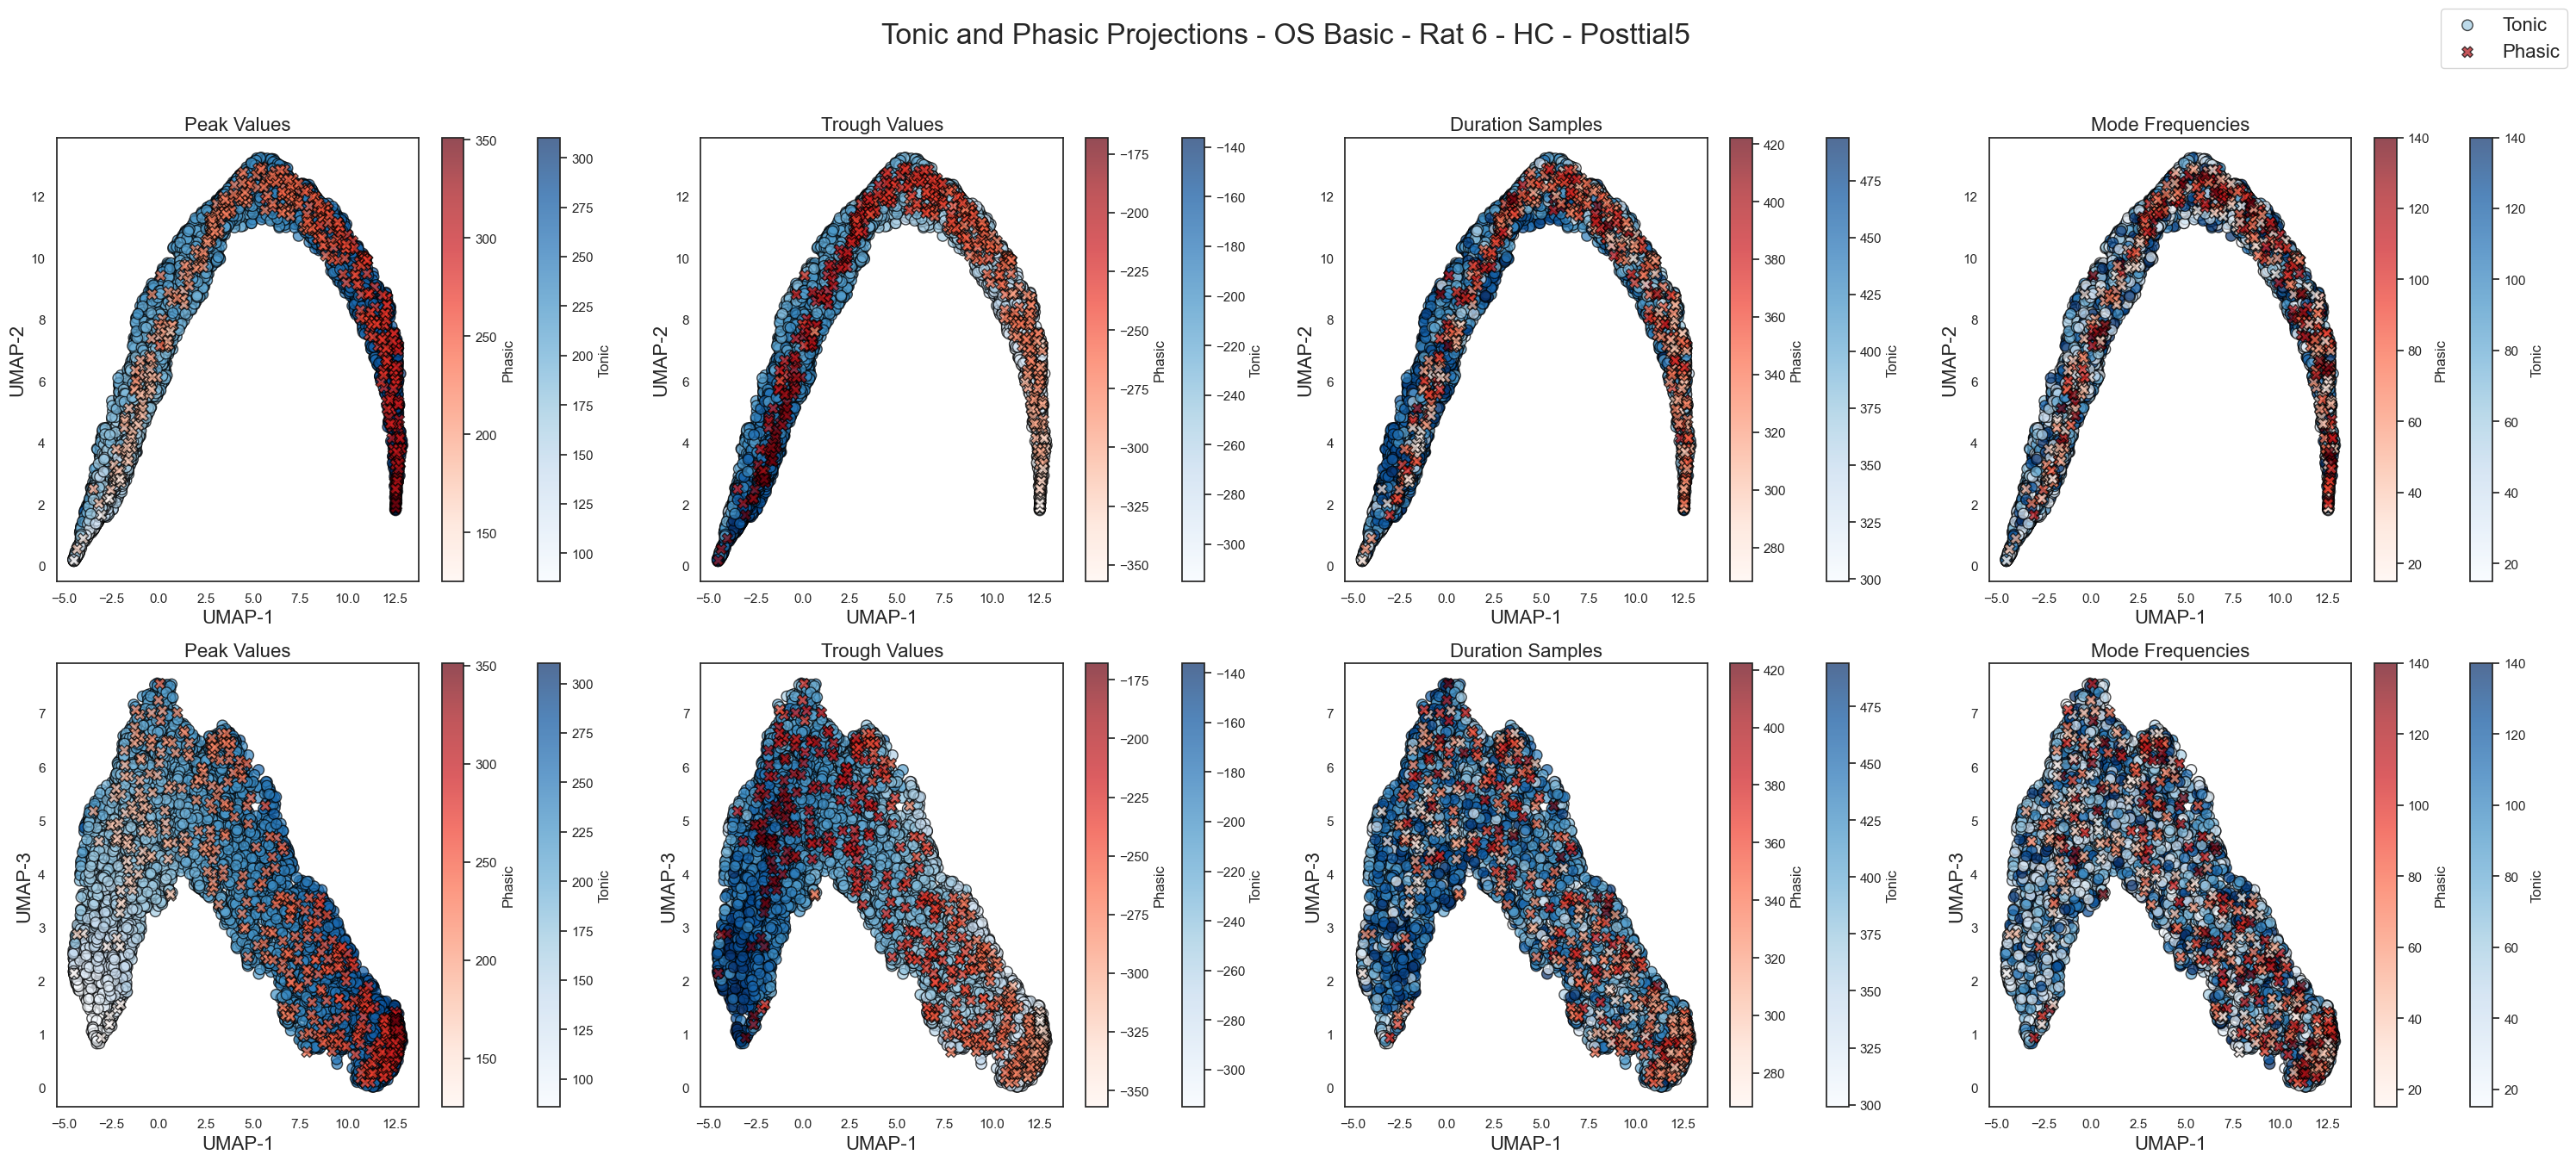

In [28]:
metrics = ['peak_values', 'trough_values', 'duration_samples', 'mode_freqs']
titles = ['Peak Values', 'Trough Values', 'Duration Samples', 'Mode Frequencies']

tonic_cmap = 'Blues'
phasic_cmap = 'Reds'

f, ax = plt.subplots(2, 4, figsize=(30, 14))

for i, metric in enumerate(metrics):
    # Tonic episodes
    scatter_tonic = ax[0, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    scatter_phasic = ax[0, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[0, i].set_xlabel('UMAP-1', fontsize=16)
    ax[0, i].set_ylabel('UMAP-2', fontsize=16)
    ax[0, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[0, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[0, i], label='Phasic', orientation='vertical')

    # UMAP-1 vs UMAP-3
    scatter_tonic = ax[1, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    scatter_phasic = ax[1, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[1, i].set_xlabel('UMAP-1', fontsize=16)
    ax[1, i].set_ylabel('UMAP-3', fontsize=16)
    ax[1, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[1, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[1, i], label='Phasic', orientation='vertical')

handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle(f"Tonic and Phasic Projections - {dataset_info['dataset_type']} - Rat {dataset_info['rat_number']} - {dataset_info['treatment']} - Posttial{dataset_info['post_trial']}", fontsize=24)
plt.savefig(f"tonic_and_phasic_projections_{dataset_info['dataset_type']}_rat{dataset_info['rat_number']}_{dataset_info['treatment']}_posttial{dataset_info['post_trial']}.svg")
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

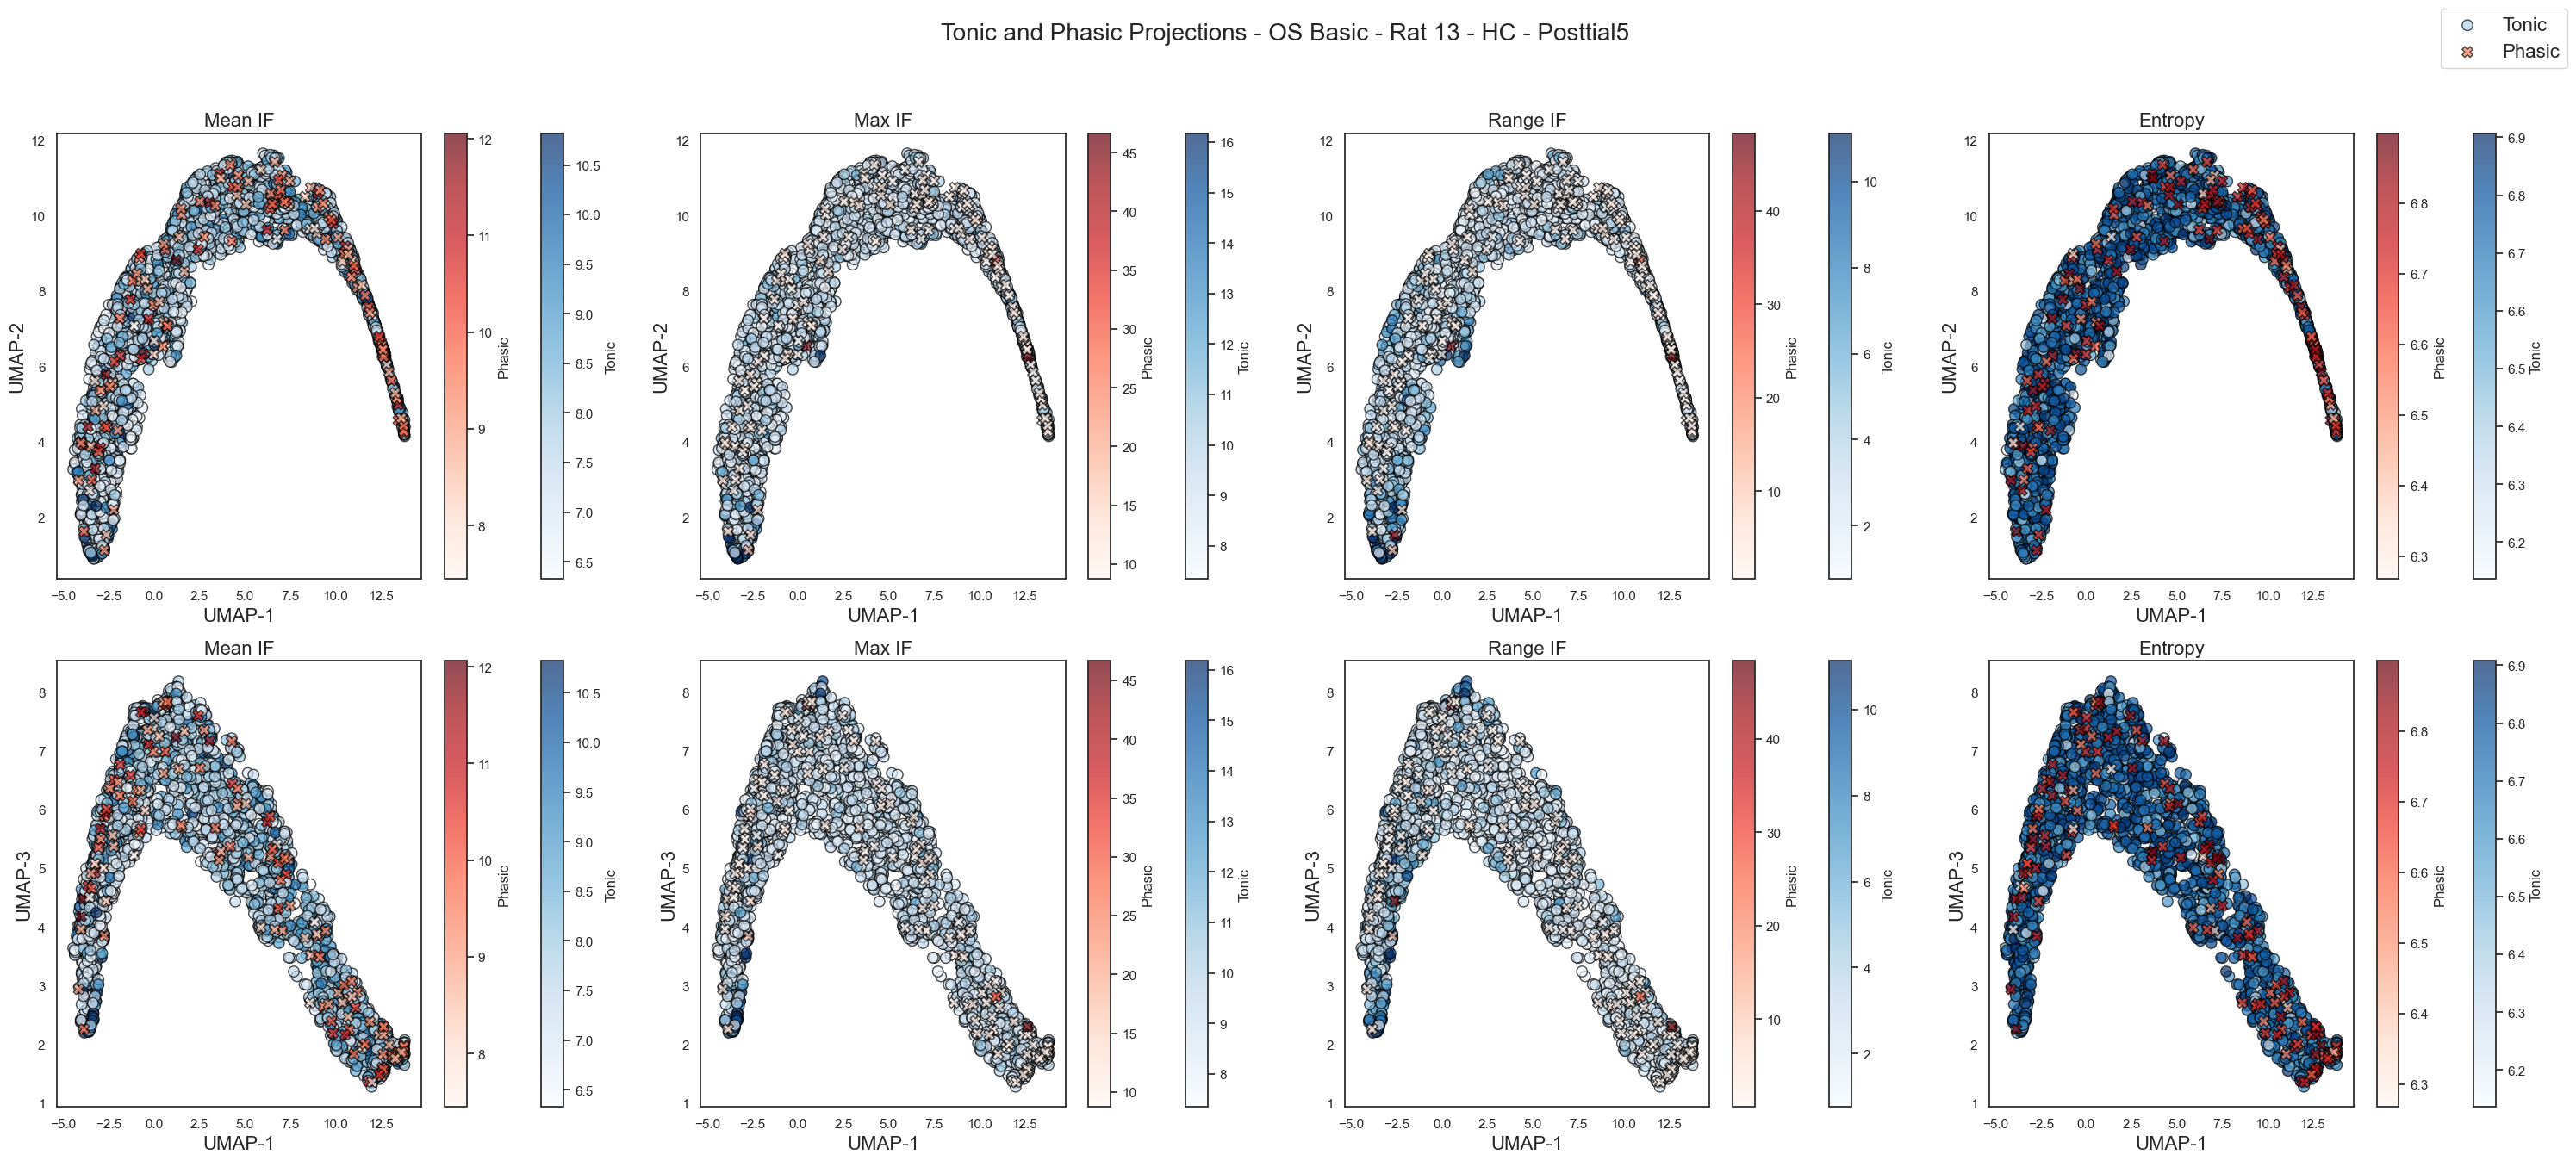

In [252]:
metrics = ['mean_if', 'max_if', 'range_if', 'entropy']
titles = ['Mean IF', 'Max IF', 'Range IF', 'Entropy']

tonic_cmap = 'Blues'
phasic_cmap = 'Reds'

f, ax = plt.subplots(2, 4, figsize=(30, 14))

for i, metric in enumerate(metrics):
    # Tonic episodes
    scatter_tonic = ax[0, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    scatter_phasic = ax[0, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[0, i].set_xlabel('UMAP-1', fontsize=16)
    ax[0, i].set_ylabel('UMAP-2', fontsize=16)
    ax[0, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[0, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[0, i], label='Phasic', orientation='vertical')

    # UMAP-1 vs UMAP-3
    scatter_tonic = ax[1, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    scatter_phasic = ax[1, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[1, i].set_xlabel('UMAP-1', fontsize=16)
    ax[1, i].set_ylabel('UMAP-3', fontsize=16)
    ax[1, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[1, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[1, i], label='Phasic', orientation='vertical')

handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

# plt.suptitle(f"Tonic and Phasic Projections - {dataset_info['dataset_type']} - Rat {dataset_info['rat_number']} - {dataset_info['treatment']} - Posttial{dataset_info['post_trial']}", fontsize=20)
# plt.savefig(f"tonic_and_phasic_projections_{dataset_info['dataset_type']}_rat{dataset_info['rat_number']}_{dataset_info['treatment']}_posttial{dataset_info['post_trial']}_entropy.svg")

plt.suptitle(f"Tonic and Phasic Projections - {dataset_info['dataset_type']} - Rat {dataset_info['rat_number']} - HC - Posttial{dataset_info['post_trial']}", fontsize=20)
plt.savefig(f"tonic_and_phasic_projections_{dataset_info['dataset_type']}_rat{dataset_info['rat_number']}_HC_posttial{dataset_info['post_trial']}_entropy.svg")
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

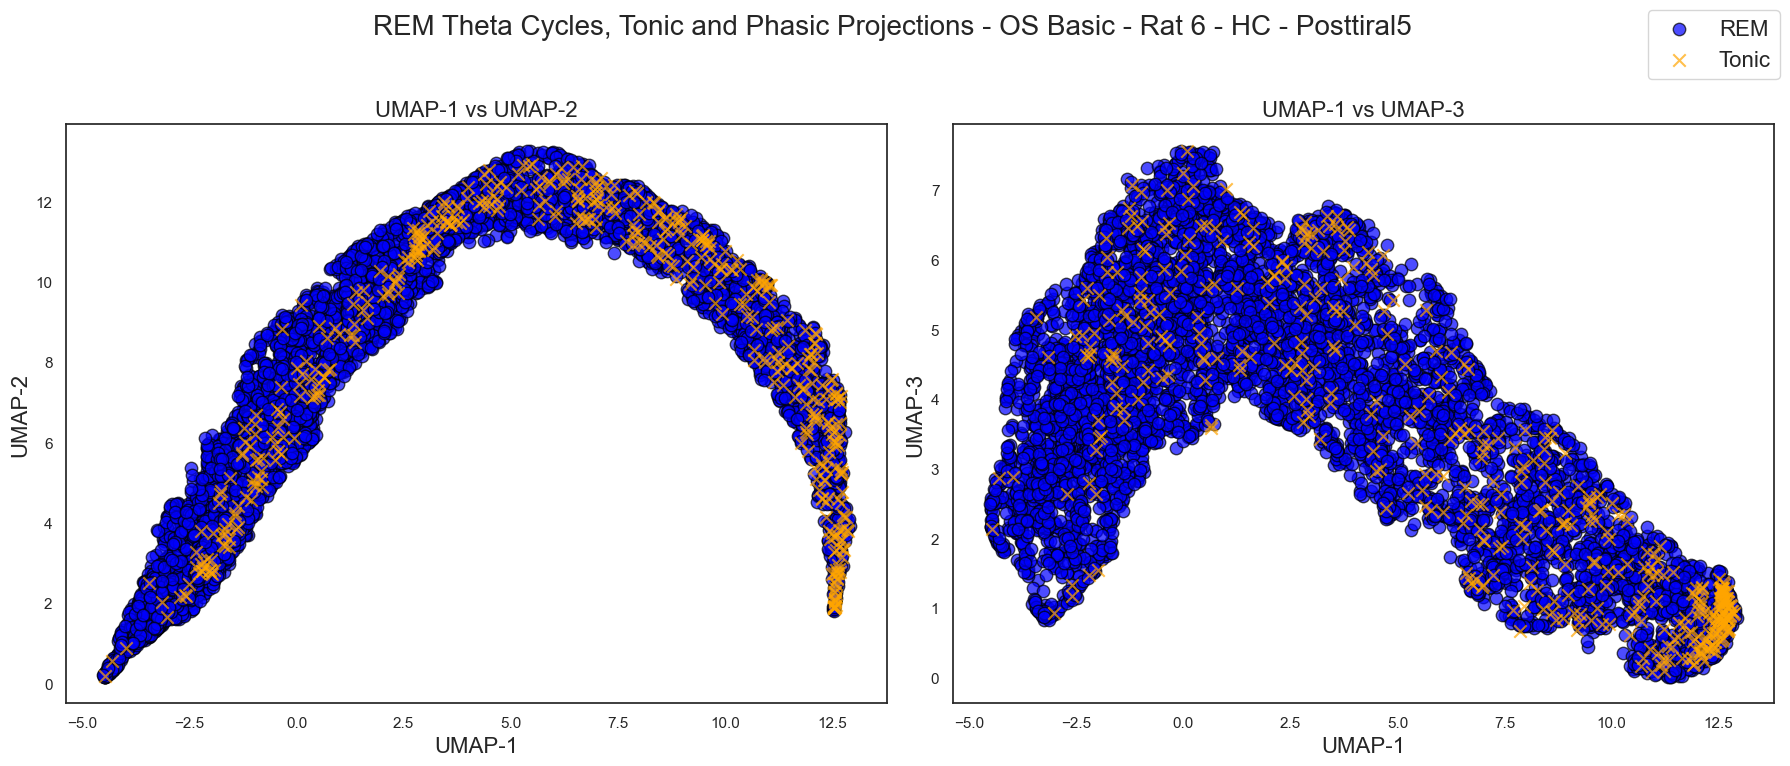

In [26]:
rem_color = 'purple'
tonic_color = 'blue'
phasic_color = 'orange'

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot UMAP-1 vs UMAP-2
# REM episodes
# scatter_rem = ax[0].scatter(embedding_rem[:, 0], embedding_rem[:, 1],
#                             c=rem_color, label='REM', s=80, alpha=0.3)

# Tonic episodes
scatter_tonic = ax[0].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                              c=tonic_color, label='Tonic', s=80, alpha=0.7, edgecolor='black')

# Phasic episodes
scatter_phasic = ax[0].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                               c=phasic_color, label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[0].set_xlabel('UMAP-1', fontsize=16)
ax[0].set_ylabel('UMAP-2', fontsize=16)
ax[0].set_title('UMAP-1 vs UMAP-2', fontsize=16)

# Plot UMAP-1 vs UMAP-3
# scatter_rem = ax[1].scatter(embedding_rem[:, 0], embedding_rem[:, 2],
#                             c=rem_color, label='REM', s=80, alpha=0.3)

scatter_tonic = ax[1].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                              c=tonic_color, label='Tonic', s=80, alpha=0.7, edgecolor='black')

scatter_phasic = ax[1].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                               c=phasic_color, label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[1].set_xlabel('UMAP-1', fontsize=16)
ax[1].set_ylabel('UMAP-3', fontsize=16)
ax[1].set_title('UMAP-1 vs UMAP-3', fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, ['REM', 'Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle(f"REM Theta Cycles, Tonic and Phasic Projections - {dataset_info['dataset_type']} - Rat {dataset_info['rat_number']} - {dataset_info['treatment']} - Posttiral{dataset_info['post_trial']}", fontsize=20)
plt.savefig(f"rem_theta_with_phasic_and_tonic_projections_{dataset_info['dataset_type']}_rat{dataset_info['rat_number']}_{dataset_info['treatment']}_Posttiral{dataset_info['post_trial']}.svg")
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Trial analysis

In [101]:
path_to_trial2_lfp = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_11-37-30_post_trial2/HPC_100_CH8_0.continuous.mat'
path_to_trial2_state = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_11-37-30_post_trial2/2019-05-15_11-37-30_post_trial2-states.mat'

path_to_trial3_lfp = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_12-27-45_post_trial3/HPC_100_CH8_0.continuous.mat'
path_to_trial3_state = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_12-27-45_post_trial3/2019-05-15_12-27-45_post_trial3-states.mat'

path_to_trial4_lfp = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_13-17-54_post_trial4/HPC_100_CH8_0.continuous.mat'
path_to_trial4_state = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_13-17-54_post_trial4/2019-05-15_13-17-54_post_trial4-states.mat'

path_to_trial5_lfp = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_14-08-14_post_trial5/HPC_100_CH8_0.continuous.mat'
path_to_trial5_state = '/Users/amir/Desktop/for Abdel/OS Basic/13/Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019/2019-05-15_14-08-14_post_trial5/2019-05-15_14-08-14_post_trial5-states.mat'

In [102]:
dataset_info = extract_experiment_info(path_to_trial5_lfp)
print(dataset_info)

{'dataset_type': 'OS Basic', 'rat_number': '13', 'treatment': 'HC', 'post_trial': '5'}


In [103]:
fs=2500

In [104]:
lfpHPC2, hypno2, _ = get_data(path_to_trial2_lfp, path_to_trial2_state)
lfpHPC3, hypno3, _ = get_data(path_to_trial3_lfp, path_to_trial3_state)
lfpHPC4, hypno4, _ = get_data(path_to_trial4_lfp, path_to_trial4_state)
lfpHPC5, hypno5, _ = get_data(path_to_trial5_lfp, path_to_trial5_state)

There was 0 in the dataset
There was 0 in the dataset
There was 0 in the dataset


In [105]:
phasic_interval2, tonic_interval2, lfp2 = extract_pt_intervals(lfpHPC2, hypno2)
#phasic_interval2, tonic_interval2, lfp2 = [[], [], []]
phasic_interval3, tonic_interval3, lfp3 = extract_pt_intervals(lfpHPC3, hypno3)
#phasic_interval3, tonic_interval3, lfp3 = [[], [], []]
phasic_interval4, tonic_interval4, lfp4 = extract_pt_intervals(lfpHPC4, hypno4)
phasic_interval5, tonic_interval5, lfp5 = extract_pt_intervals(lfpHPC5, hypno5)

Number of detected Tonic intrevals:9
Number of detected Tonic intrevals after threshold:8
Number of detected Tonic intrevals:10
Number of detected Tonic intrevals after threshold:10
Number of detected Tonic intrevals:4
Number of detected Tonic intrevals after threshold:4
Number of detected Tonic intrevals:16
Number of detected Tonic intrevals after threshold:16


In [106]:
tonic_imfs2, tonic_imfs_freqs2, tonic_rem_lpf2 = extract_imfs_by_pt_intervals(lfp2, fs, tonic_interval2, config, return_imfs_freqs=True)
tonic_imfs3, tonic_imfs_freqs3, tonic_rem_lpf3 = extract_imfs_by_pt_intervals(lfp3, fs, tonic_interval3, config, return_imfs_freqs=True)
tonic_imfs4, tonic_imfs_freqs4, tonic_rem_lpf4 = extract_imfs_by_pt_intervals(lfp4, fs, tonic_interval4, config, return_imfs_freqs=True)
tonic_imfs5, tonic_imfs_freqs5, tonic_rem_lpf5 = extract_imfs_by_pt_intervals(lfp5, fs, tonic_interval5, config, return_imfs_freqs=True)

In [107]:
phasic_imfs2, phasic_imfs_freqs2, rem_lpf2 = extract_imfs_by_pt_intervals(lfp2, fs, phasic_interval2, config, return_imfs_freqs=True)
phasic_imfs3, phasic_imfs_freqs3, rem_lpf3 = extract_imfs_by_pt_intervals(lfp3, fs, phasic_interval3, config, return_imfs_freqs=True)
phasic_imfs4, phasic_imfs_freqs4, rem_lpf4 = extract_imfs_by_pt_intervals(lfp4, fs, phasic_interval4, config, return_imfs_freqs=True)
phasic_imfs5, phasic_imfs_freqs5, rem_lpf5 = extract_imfs_by_pt_intervals(lfp5, fs, phasic_interval5, config, return_imfs_freqs=True)

In [108]:
# Initialize empty DataFrames for concatenation
all_phasic_waveforms = pd.DataFrame()
all_phasic_trials = pd.DataFrame()
all_tonic_waveforms = pd.DataFrame()
all_tonic_trials = pd.DataFrame()

# List of trials and intervals for easier looping
phasic_imfs_list = [phasic_imfs2, phasic_imfs3, phasic_imfs4, phasic_imfs5]
phasic_freqs_list = [phasic_imfs_freqs2, phasic_imfs_freqs3, phasic_imfs_freqs4, phasic_imfs_freqs5]
tonic_imfs_list = [tonic_imfs2, tonic_imfs3, tonic_imfs4, tonic_imfs5]
tonic_freqs_list = [tonic_imfs_freqs2, tonic_imfs_freqs3, tonic_imfs_freqs4, tonic_imfs_freqs5]

# Loop over trials to extract waveforms and trials data
for i, (phasic_imfs, phasic_freqs, tonic_imfs, tonic_freqs) in enumerate(zip(phasic_imfs_list, phasic_freqs_list, tonic_imfs_list, tonic_freqs_list)):
    phasic_waveforms, phasic_trials, _ = prepare_data_for_umap(phasic_imfs, phasic_freqs)
    tonic_waveforms, tonic_trials, _ = prepare_data_for_umap(tonic_imfs, tonic_freqs)
    
    # Add trial index for color-coding in UMAP
    phasic_waveforms['posttrial'] = i + 1
    phasic_trials['posttrial'] = i + 1
    tonic_waveforms['posttrial'] = i + 1
    tonic_trials['posttrial'] = i + 1

    # Concatenate across trials
    all_phasic_waveforms = pd.concat([all_phasic_waveforms, phasic_waveforms], ignore_index=True)
    all_phasic_trials = pd.concat([all_phasic_trials, phasic_trials], ignore_index=True)
    all_tonic_waveforms = pd.concat([all_tonic_waveforms, tonic_waveforms], ignore_index=True)
    all_tonic_trials = pd.concat([all_tonic_trials, tonic_trials], ignore_index=True)

# Step 2: Combine Phasic and Tonic Waveforms for UMAP Embedding
combined_waveforms = pd.concat([all_phasic_waveforms, all_tonic_waveforms], ignore_index=True)
combined_waveforms = combined_waveforms.drop(columns=['posttrial']).to_numpy()  # Drop 'trial' column for UMAP

 Checking Cycles inputs - trimming singleton from input 'IP'
2815
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
5495
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
10335
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
11000
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
7325
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
123020
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
51135
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
18250
 Che

In [109]:
# # Step 3: Determine ID for UMAP Embedding (Dimensionality Reduction)
# ID = np.round(np.nanmean(abids(combined_waveforms, 50)))

In [110]:
ID = 3

In [111]:
# Apply UMAP to the Combined Waveforms
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=int(ID), metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(combined_waveforms)

In [112]:
# Transform phasic and tonic waveforms individually using the fitted UMAP embedder
phasic_projection = umap_embedder.transform(all_phasic_waveforms.drop(columns=['posttrial']).to_numpy())
tonic_projection = umap_embedder.transform(all_tonic_waveforms.drop(columns=['posttrial']).to_numpy())

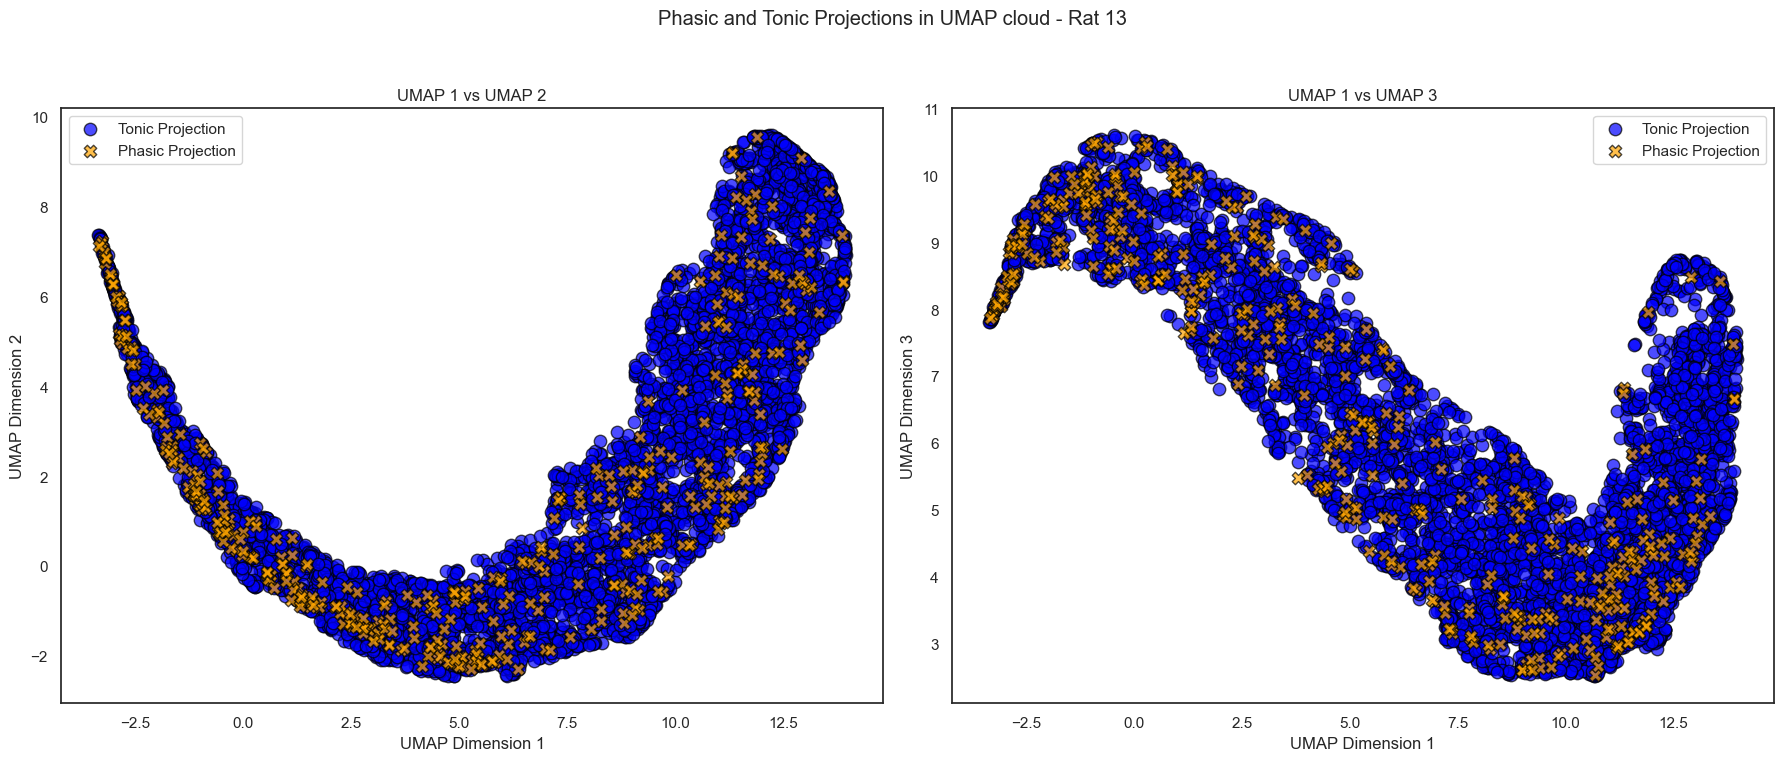

In [113]:
import matplotlib.pyplot as plt

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: UMAP 1 vs UMAP 2
axes[0].scatter(tonic_projection[:, 0], tonic_projection[:, 1], color="blue", s=80, alpha=0.7, label="Tonic Projection", edgecolor='black')
axes[0].scatter(phasic_projection[:, 0], phasic_projection[:, 1], color="orange", s=80, alpha=0.7, marker='X', label="Phasic Projection", edgecolor='black')
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")
axes[0].set_title("UMAP 1 vs UMAP 2")
axes[0].legend()

# Second subplot: UMAP 1 vs UMAP 3
axes[1].scatter(tonic_projection[:, 0], tonic_projection[:, 2], color="blue", s=80, alpha=0.7, label="Tonic Projection", edgecolor='black')
axes[1].scatter(phasic_projection[:, 0], phasic_projection[:, 2], color="orange", s=80, alpha=0.7, marker='X', label="Phasic Projection", edgecolor='black')
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 3")
axes[1].set_title("UMAP 1 vs UMAP 3")
axes[1].legend()

# Display the plot
plt.suptitle(f"Phasic and Tonic Projections in UMAP cloud - Rat {dataset_info['rat_number']}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"UMAP_for_rat{dataset_info['rat_number']}.svg")
plt.show()